Grupo: Mateus Padilha, Breno de Souza e Ian Esteves

# **DESAFIO**

Vamos trabalhar alguns cenários onde utilizaremos RNAs MLP para resolver problemas que envolvem imagens.

# **Classificação de estilo artístico por histograma de cores**

## **O problema**

O objetivo é classificar a corrente artística de uma pintura (ex: Impressionismo, Surrealismo, Renascimento).

## **O Conjunto de Dados**

Utilizaremos o dataset **"Painter by Numbers"** do [Kaggle](https://www.kaggle.com/competitions/painter-by-numbers/data), que contém milhares de pinturas rotuladas por artista, estilo e gênero. As informações sobre a base estão no mesmo link.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Carrega o dataset
df = pd.read_csv("all_data_info.csv")

# Verificar colunas disponíveis
print("Colunas:", df.columns.tolist())
print("Valores nulos por coluna:\n", df.isnull().sum())


Colunas: ['artist', 'date', 'genre', 'pixelsx', 'pixelsy', 'size_bytes', 'source', 'style', 'title', 'artist_group', 'in_train', 'new_filename']
Valores nulos por coluna:
 artist              0
date            26363
genre            1254
pixelsx             0
pixelsy             0
size_bytes          0
source            167
style             986
title             122
artist_group        0
in_train            0
new_filename        0
dtype: int64


In [ ]:
# Caminho do arquivo CSV
df = pd.read_csv("all_data_info.csv")

# Verificar classes e balanceamento
print(df['style'].value_counts())


style
Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: count, Length: 136, dtype: int64


In [ ]:
# Verificando valores ausentes em cada coluna
print("\nValores ausentes por coluna:")
print(df.isnull().sum())

# Porcentagem de valores ausentes
print("\nPorcentagem de valores ausentes:")
print((df.isnull().mean() * 100).round(2))



Valores ausentes por coluna:
artist              0
date            26363
genre            1254
pixelsx             0
pixelsy             0
size_bytes          0
source            167
style             986
title             122
artist_group        0
in_train            0
new_filename        0
dtype: int64

Porcentagem de valores ausentes:
artist           0.00
date            25.53
genre            1.21
pixelsx          0.00
pixelsy          0.00
size_bytes       0.00
source           0.16
style            0.95
title            0.12
artist_group     0.00
in_train         0.00
new_filename     0.00
dtype: float64


Observações importantes

Encontramos colunas com valores nulos (date ~25%).

A coluna alvo style tem alguns nulos (~0.95%) — esses foram removidos antes de treinar.


Número de estilos únicos: 136

Distribuição dos estilos:
style
Impressionism              10643
Realism                    10523
Romanticism                 9285
Expressionism               7013
Post-Impressionism          5778
Art Nouveau (Modern)        4899
Baroque                     4400
Surrealism                  4167
Symbolism                   3476
Rococo                      2733
Northern Renaissance        2379
Naïve Art (Primitivism)     2295
Abstract Expressionism      2074
Neoclassicism               2038
Cubism                      1747
Name: count, dtype: int64


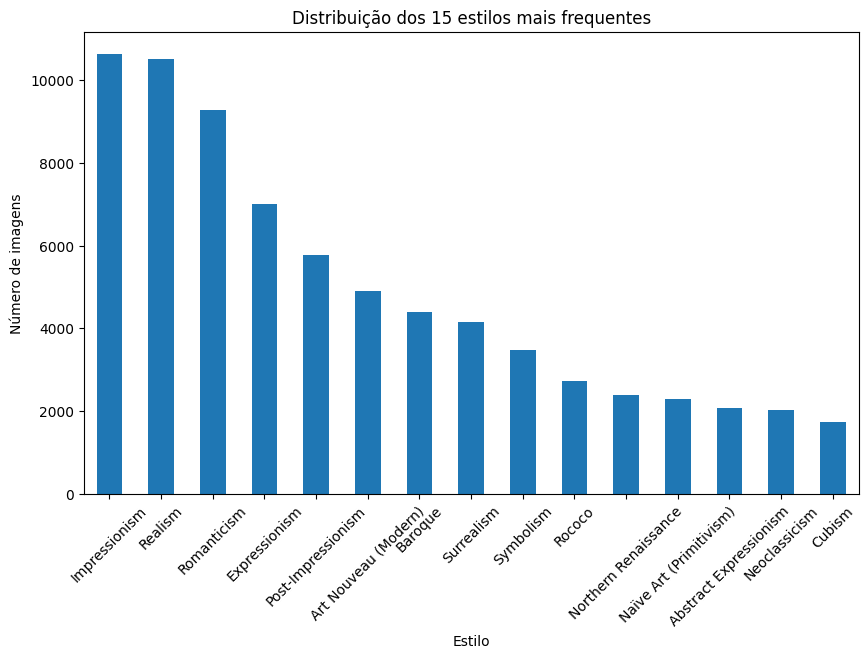

In [ ]:
# Quantos estilos únicos existem?
print("\nNúmero de estilos únicos:", df['style'].nunique())

# Distribuição dos estilos
print("\nDistribuição dos estilos:")
print(df['style'].value_counts().head(15))  # mostra os 20 mais comuns

# Visualizar graficamente
plt.figure(figsize=(10,6))
df['style'].value_counts().head(15).plot(kind='bar')
plt.title("Distribuição dos 15 estilos mais frequentes")
plt.xlabel("Estilo")
plt.ylabel("Número de imagens")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Selecionar colunas relevantes

# Variável alvo
target = 'style'

# Features (numéricas + categóricas codificadas)
features = ['pixelsx', 'pixelsy', 'size_bytes', 'genre', 'source', 'artist_group']

# Remover linhas com valores nulos nessas colunas
df = df[features + [target]].dropna()


Escolhemos as colunas para treinar o modelo e removemos linhas com valores nulos nessas colunas. Optamos por usar esses metadados (resolução pixelsx/pixelsy, size_bytes, e colunas categóricas genre, source, artist_group) — porque são fáceis de extrair e já estão no CSV.

In [ ]:
# ============================================
# Codifica variáveis categóricas
# ============================================
df_encoded = df.copy()
for col in ['genre', 'source', 'artist_group']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

LabelEncoder: converte as categorias textuais para inteiros, permitindo que a MLP consuma essas features.

In [ ]:
# ============================================
# Balanceamento (oversampling)
# ============================================
max_size = df_encoded[target].value_counts().max()
lst = []

for class_index, group in df_encoded.groupby(target):
    lst.append(group.sample(max_size, replace=True))

df_balanced = pd.concat(lst).reset_index(drop=True)

print("Distribuição após balanceamento:")
print(df_balanced[target].value_counts())


Distribuição após balanceamento:
style
Abstract Art              10643
Abstract Expressionism    10643
Academicism               10643
Action painting           10643
American Realism          10643
                          ...  
Tubism                    10643
Ukiyo-e                   10643
Verism                    10643
Yamato-e                  10643
Zen                       10643
Name: count, Length: 136, dtype: int64


Aumenta todas as classes até o tamanho da maior, produzindo um dataset mais balanceado, para evitar que classes majoritárias dominem o aprendizado.

In [ ]:
# ============================================
# Preparar X e y
# ============================================
X = df_balanced[features].values
y = df_balanced[target].values

# Codifica o rótulo (style)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normaliza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

LabelEncoder + to_categorical: converte labels para vetores one-hot exigidos pelo categorical_crossentropy.

StandardScaler: centraliza e escala features numéricas, o que ajuda convergência da rede (camadas densas respondem melhor a features padronizadas).

In [ ]:
# ============================================
# Divisão em treino e teste
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42
)


In [ ]:
# ============================================
# Criação e treinanamento da MLP
# ============================================
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.1428 - loss: 3.8321 - val_accuracy: 0.3040 - val_loss: 2.9887
Epoch 2/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.2565 - loss: 3.1995 - val_accuracy: 0.3434 - val_loss: 2.7585
Epoch 3/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.2838 - loss: 3.0458 - val_accuracy: 0.3625 - val_loss: 2.6459
Epoch 4/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.2977 - loss: 2.9690 - val_accuracy: 0.3792 - val_loss: 2.5903
Epoch 5/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3066 - loss: 2.9201 - val_accuracy: 0.3825 - val_loss: 2.5414
Epoch 6/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.3116 - loss: 2.8947 - val_accuracy: 0.3917 - val_loss: 2.5176
Epoch 7/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3158 - loss: 2.8751 - val_accuracy: 0.3957 - val_loss: 2.4929
Epoch 8/30
9047/9047 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3195 - loss: 2

Arquitetura: 2 camadas densas (128 -> 64) com relu, dropout 0.3 para regularização e camada final softmax para classificação multiclasses.

Loss categorical_crossentropy e otimizador adam: escolhas padrão eficazes.

batch_size=128 e epochs=30: valores razoáveis para começar.

Dropout ajuda a mitigar overfitting.

In [ ]:
# ============================================
# 9. Avaliar o modelo
# ============================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAcurácia no teste: {acc:.4f}")



Acurácia no teste: 0.4269


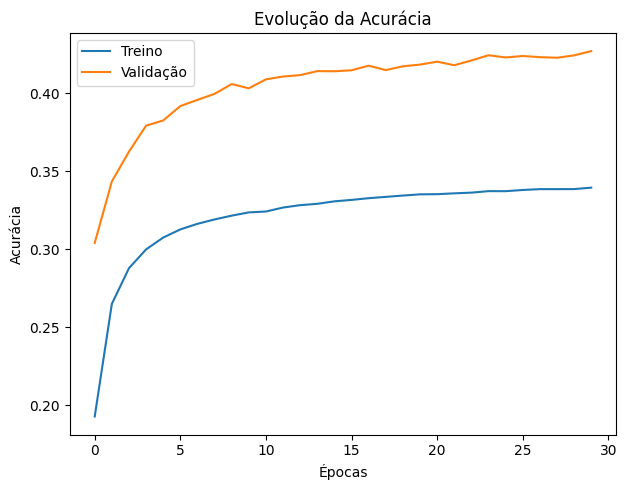

In [ ]:
# ============================================
# Curva de aprendizado (Acurácia)
# ============================================
plt.figure(figsize=(12,5))

# Acurácia
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


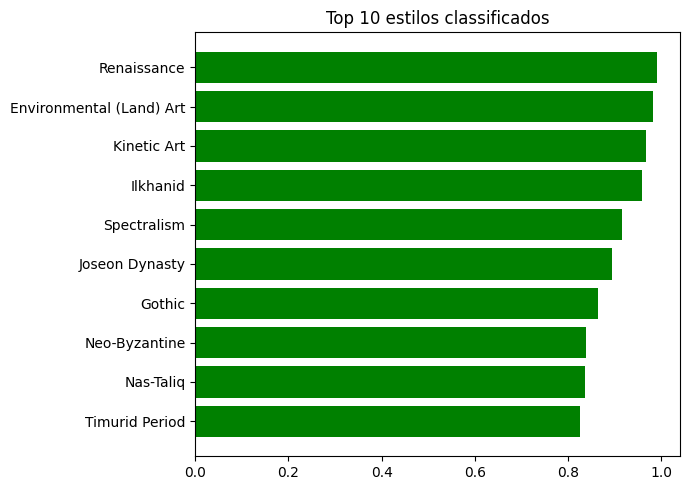

In [ ]:
# ============================================
# Ranking de desempenho por estilo
# ============================================

# Calcular métricas por classe
precisions = precision_score(y_true, y_pred_classes, average=None, zero_division=0)
recalls = recall_score(y_true, y_pred_classes, average=None, zero_division=0)
f1s = f1_score(y_true, y_pred_classes, average=None, zero_division=0)

df_metrics = pd.DataFrame({
    'Style': le_target.classes_,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1s
}).sort_values(by='F1-Score', ascending=False)

# Top 10
top10 = df_metrics.head(10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.barh(top10['Style'], top10['F1-Score'], color='green')
plt.title('Top 10 estilos classificados')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


Referências principais de documentação:

-> Slides de Redes Neurais, Gemini e ChatGPT